<a href="https://colab.research.google.com/github/TonioHathos/AI_Valeo/blob/main/Code_Yudi/Mod%C3%A8le_Yudi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score, precision_score, \
                        recall_score, precision_recall_curve, roc_curve, \
                        roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler



# I prepared these libraries for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from andrea_models import subsample
from visualization import silhouette_diagram, plot_conf_mat, \
                      false_positive_rate, evaluate_anomaly_detector

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard



# The following is to be able to mount Google Drive
from google.colab import drive

import os
from os.path import isfile
import datetime
import shutil
from functools import partial, partialmethod



# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF


# To show time at each cell
# Credits to https://medium.com/@arptoth/how-to-measure-execution-time-in-google-colab-707cc9aad1c8
!pip install ipython-autotime 
%load_ext autotime

--2023-05-30 12:50:14--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py’

andrea_models.py    100%[===================>]   3.12K  --.-KB/s    in 0s      

2023-05-30 12:50:14 (57.2 MB/s) - ‘andrea_models.py’ saved [3190/3190]

--2023-05-30 12:50:15--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP

#PreProcessing

In [2]:
! rm -f *.csv
! wget https://raw.githubusercontent.com/TonioHathos/AI_Valeo/master/df_training_mod.csv
df_training_mod = pd.read_csv('df_training_mod.csv')

--2023-05-30 12:51:32--  https://raw.githubusercontent.com/TonioHathos/AI_Valeo/master/df_training_mod.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2666373 (2.5M) [text/plain]
Saving to: ‘df_training_mod.csv’

df_training_mod.csv 100%[===================>]   2.54M  --.-KB/s    in 0.06s   

2023-05-30 12:51:32 (39.4 MB/s) - ‘df_training_mod.csv’ saved [2666373/2666373]

time: 685 ms (started: 2023-05-30 12:51:32 +00:00)


In [18]:
! rm -f *.csv
! wget https://raw.githubusercontent.com/TonioHathos/AI_Valeo/main/Code_Yudi/df_yudi.csv
df_training_mod = pd.read_csv('df_yudi.csv')



--2023-05-30 13:14:18--  https://raw.githubusercontent.com/TonioHathos/AI_Valeo/main/Code_Yudi/df_yudi.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3334811 (3.2M) [text/plain]
Saving to: ‘df_yudi.csv’

df_yudi.csv         100%[===================>]   3.18M  --.-KB/s    in 0.07s   

2023-05-30 13:14:18 (46.6 MB/s) - ‘df_yudi.csv’ saved [3334811/3334811]

time: 386 ms (started: 2023-05-30 13:14:17 +00:00)


In [63]:
df_training_mod.describe()

,Rodage_U,V1_torque,Rodage_I,V2_torque,SnapRingMidPointForce,Premier angle,SnapRingPeakForce,Deuxième angle,Vissage_M8_torque,Capuchon_insertion,StartLinePeakForce,Vissage_M8_angle_log,SnapRingFinalStroke_exp,Binar OP130_Resultat_Global_v
count,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000
mean,11.971027,0.688628,113.350222,0.693467,97.700978,159.906922,156.915055,159.618236,12.256785,0.460322,23.630152,2.826255,433255.325067,0.008837
std,0.003050,0.463061,3.528522,0.461061,6.837714,15.662650,11.271492,15.091490,0.065319,0.498430,2.546341,0.325871,53512.641384,0.093589
min,11.970000,0.000000,99.990000,0.000000,0.000000,101.800000,0.000000,82.000000,12.030000,0.000000,0.000000,1.840550,2.718282,0.000000
25%,11.970000,0.000000,111.040000,0.000000,94.310000,148.700000,149.210000,149.400000,12.210000,0.000000,22.280000,2.602690,380788.735379,0.000000
50%,11.970000,1.000000,113.160000,1.000000,98.500000,158.000000,156.180000,158.700000,12.260000,0.000000,23.880000,2.797281,460468.625050,0.000000
75%,11.970000,1.000000,115.380000,1.000000,102.230000,169.300000,164.380000,168.900000,12.300000,1.000000,25.290000,3.005683,479260.706129,0.000000
max,11.990000,1.000000,177.950000,1.000000,127.300000,198.300000,196.920000,198.100000,12.500000,1.000000,43.410000,4.437934,534988.216285,1.000000


time: 665 ms (started: 2023-05-30 14:37:26 +00:00)


In [23]:
df_training_mod.columns

Index(['Rodage_U', 'V1_torque', 'Rodage_I', 'V2_torque',
       'SnapRingMidPointForce', 'Premier angle', 'SnapRingPeakForce',
       'Deuxième angle', 'Vissage_M8_torque', 'Capuchon_insertion',
       'StartLinePeakForce', 'Vissage_M8_angle_log', 'SnapRingFinalStroke_exp',
       'Binar OP130_Resultat_Global_v'],
      dtype='object')

time: 8.84 ms (started: 2023-05-30 13:17:12 +00:00)


In [66]:
df_training_mod = df_training_mod.drop(columns=['V1_torque'])

time: 21.1 ms (started: 2023-05-30 14:40:05 +00:00)


In [67]:
df_train, df_test = train_test_split(df_training_mod, test_size=0.3, random_state=19)
df_test.head()

print('Training samples ', df_train.shape[0], '; Test samples ', df_test.shape[0])


Training samples  24160 ; Test samples  10355
time: 19.5 ms (started: 2023-05-30 14:40:09 +00:00)


In [70]:
columns = ['Rodage_U', 'Rodage_I', 'V2_torque',
       'SnapRingMidPointForce', 'Premier angle', 'SnapRingPeakForce',
       'Deuxième angle', 'Vissage_M8_torque', 'Capuchon_insertion',
       'StartLinePeakForce', 'Vissage_M8_angle_log', 'SnapRingFinalStroke_exp']

time: 595 µs (started: 2023-05-30 14:40:19 +00:00)


In [71]:
X_train = df_train[columns]
X_test = df_test[columns]

y_train = df_train['Binar OP130_Resultat_Global_v']
y_test = df_test['Binar OP130_Resultat_Global_v']

time: 4.14 ms (started: 2023-05-30 14:40:20 +00:00)


In [72]:
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_train)

time: 16.2 ms (started: 2023-05-30 14:40:23 +00:00)


In [73]:
n_features = X_tr_scaled.shape[1]
print("The number of features is ", n_features)

The number of features is  12
time: 2.07 ms (started: 2023-05-30 14:40:25 +00:00)


#Value Counting

In [74]:
y_train.value_counts()

0    23934
1      226
Name: Binar OP130_Resultat_Global_v, dtype: int64

time: 7.14 ms (started: 2023-05-30 14:40:28 +00:00)


In [75]:
y_test.value_counts()

0    10276
1       79
Name: Binar OP130_Resultat_Global_v, dtype: int64

time: 4.28 ms (started: 2023-05-30 14:40:29 +00:00)


Lets balance the dataset

In [76]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
pd.value_counts(y_train_balanced)

0    23934
1    23934
Name: Binar OP130_Resultat_Global_v, dtype: int64

time: 44 ms (started: 2023-05-30 14:40:31 +00:00)


In [77]:
scaler = StandardScaler()
X_tr_scaled1 = scaler.fit_transform(X_train_balanced)

time: 29.8 ms (started: 2023-05-30 14:40:33 +00:00)


In [78]:
n_features1 = X_tr_scaled1.shape[1]
print("The number of features is ", n_features1)

The number of features is  12
time: 1.65 ms (started: 2023-05-30 14:40:33 +00:00)


# Neural Network

In [79]:
def make_sequential_model(sample_size, layer_sizes, 
                          hidden_activation_function="relu", 
                          out_activation_function="softmax",
                          loss_fun="categorical_crossentropy",
                          learning_rate=0.01,
                          regularization_coeff=0,
                          metrics=['accuracy']):
  """
  Makes a sequential model.
  Parameters
  -------------------------
  sample_size: integer
    The number of features of the samples

  layer_sizes: list
    List of the size of the neural network layers. For instance, if
    layer_sizes = [8, 6, 4], the 1st layer will have 5 neurons, the 2nd 6 etc.
    Attention: the size of the last layer (the output layer) is not arbitrary.
    In case of monodimensional regression, it must be 1.
    When using categorical_crossentropy, it must be the same as the number of 
    categories.
    When using binary_crossentropy, it must be 1.

  inner_activation_function: string
    Activation function used in all layers, except the last one.
    Ex: "relu"

  out_activation_function: string
    Activation function of the last layer.
    Ex. "softmax"

  loss_fun: string
    The loss function we want to minimize. Ex. categorical_crossentropy

  learning_rate: float
    Ex. 0.01

  regularization_coeff: float
    Coefficient of ridge regression
    Ex. 0.01

  metrics: list of strings
    The metrics we want to show during training. Ex. ['accuracy']
  """

  model = Sequential()


  # In the next code we will use `partial`, which is a function of the ptyhon
  # library functools, which allows to define a class, identical to another
  # class but with some different default values.
  # In our case we define MyDenseLayer equal to the standard keras class
  # `Dense`, which implements a simple neural network layer, specifying 
  # two default values: one for the activation function, and another for the
  # regularization

  if (regularization_coeff==0):
    # No regularization
    MyDenseLayer = partial(Dense, activation=hidden_activation_function)
  else:
    MyDenseLayer = partial(Dense, activation=hidden_activation_function,
                         kernel_regularizer=keras.regularizers.l2(regularization_coeff))

  # Add the input layer
  model.add( MyDenseLayer(layer_sizes[0], 
                  input_dim = sample_size) )
  
  # Add hidden layers
  for i in range(1,len(layer_sizes)-1 ): # We iterate from the 2nd element to the penultimate
    model.add( MyDenseLayer(layer_sizes[i]) )
    
  # Add output layer
  model.add( Dense(layer_sizes[-1],
                  activation = out_activation_function) )
  

  model.compile(loss=loss_fun, 
              optimizer=keras.optimizers.Adam(lr=learning_rate) ,
              metrics=metrics)
  
  return model

time: 1.67 ms (started: 2023-05-30 14:42:04 +00:00)


In [80]:
def enforce_reproducibility(seed):
  tf.keras.backend.clear_session()

  # To know more: 
  #       https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
  random.seed(seed)
  np.random.seed(random.randint(0,300000))
  tf.random.set_seed(random.randint(0,300000))

time: 798 µs (started: 2023-05-30 14:42:05 +00:00)


In [81]:
def train_model(model, nn_file, X_tr, y_tr, seed, max_epochs=1000, 
                overwrite=True, validation_split=0.2, patience=10):
  """
  model: neural network model
            It must be a compiled neural network, e.g., a model issued by the
            function make_sequential_model(..) defined before

  nn_file:  string (name of a file)
            This file will be used to store the weights of the trained neural
            network. Such weights are automatically stored during training 
            (thanks to the ModelCheckpoint callback (see the implementation 
            code)), so that even if the code fails in the middle of training,
            you can resume training without starting from scratch.
            If the file already exists, before starting training, the weights
            in such a file will be loaded, so that we do not start training from
            scratch, but we start already from (hopefully) good weigths.
  
  overwrite: boolean
            If true, the model will be built and trained from scratch, 
            indipendent of whether nn_file exists or not.

  seed: integer

  X_tr: matrix
            Feature matrix of the training set

  y_tr: matrix
            True labels of the training set

  max_epochs: integer
            Training will stop after such number of epochs

  validation_split: float (between 0 and 1)
            Fraction of training dataset that will be used as validation

  patience: integer
            Training will stop if the validation loss does not improve after the 
            specified number of epochs
  """
  
  enforce_reproducibility(seed)


  # Before starting training, Keras divides (X_tr, y_tr) into a training subset
  # and a validation subset. During iterations, Keras will do backpropagation
  # in order to minimize the loss on the trainins subset, but it will monitor 
  # and also plot the loss on the validation subset.
  # However, Keras always takes the first part of (X_tr, y_tr) as training
  # subset and the second part as validation subset. This can be bad, in case
  # the dataset has been created with a certain order (for instance all the 
  # samples with a certain characteristic first, and then all the others), as
  # we instead need to train the neural network on a representative subset of 
  # samples. For this reason, we first shuffle the dataset
  X_train, y_train = shuffle(X_tr, y_tr, random_state=seed)


  ##################
  #### CALLBACKS ###
  ##################
  # These functions are called at every epoch
  plot_cb = PlotLossesKerasTF()  # Plots the loss
  checkpoint_cb = ModelCheckpoint(nn_file) # Stores weights
  logger_cb = CSVLogger(nn_file+'.csv', append=True) # Stores history
                # see https://theailearner.com/2019/07/23/keras-callbacks-csvlogger/


  # To stop early if we already converged
  # See pagg 315-16 of [Ge19]
  early_stop_cb = tf.keras.callbacks.EarlyStopping(verbose=1,
      monitor='val_loss',
     patience=patience, restore_best_weights=True) 


  if overwrite==True:
    try:
      os.remove(nn_file)
    except OSError:
      pass

    try:
      os.remove(nn_file+'.csv')
    except OSError:
      pass

  if isfile(nn_file):
    print("Loading pre-existing model")
    model = load_model(nn_file)

  history = model.fit(X_train, y_train, epochs=max_epochs, 
                      callbacks = [plot_cb, checkpoint_cb, logger_cb, early_stop_cb], 
                      validation_split=validation_split )

  return history

time: 2.24 ms (started: 2023-05-30 14:42:05 +00:00)


# AutoEncoder

In [37]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/Apprentissage' # Always the same, don't change it

Mounted at /content/gdrive
time: 3.65 s (started: 2023-05-30 13:18:07 +00:00)


In [38]:
my_path = drive_path + \
  'Modele'

time: 653 µs (started: 2023-05-30 13:18:12 +00:00)


In [82]:
first_architecture = [10, 5, 10, n_features]
# The encoder is composed of the input layer, with one input per feature
#    and a layer of 10 neurons
# The latent representation is composed of one layer of 5 neurons
# The decoder is composed of a layer of 10 neurons and the output layer
#    


time: 786 µs (started: 2023-05-30 14:46:17 +00:00)


In [83]:
make_autoencoder = partial(make_sequential_model, sample_size=n_features,
                        hidden_activation_function='tanh',
                      out_activation_function='tanh',
                      loss_fun='mean_squared_error',
                      metrics=[])

time: 794 µs (started: 2023-05-30 14:46:19 +00:00)


In [41]:
model = make_autoencoder(layer_sizes=first_architecture)

time: 107 ms (started: 2023-05-30 13:18:19 +00:00)


First Training without SMOTE

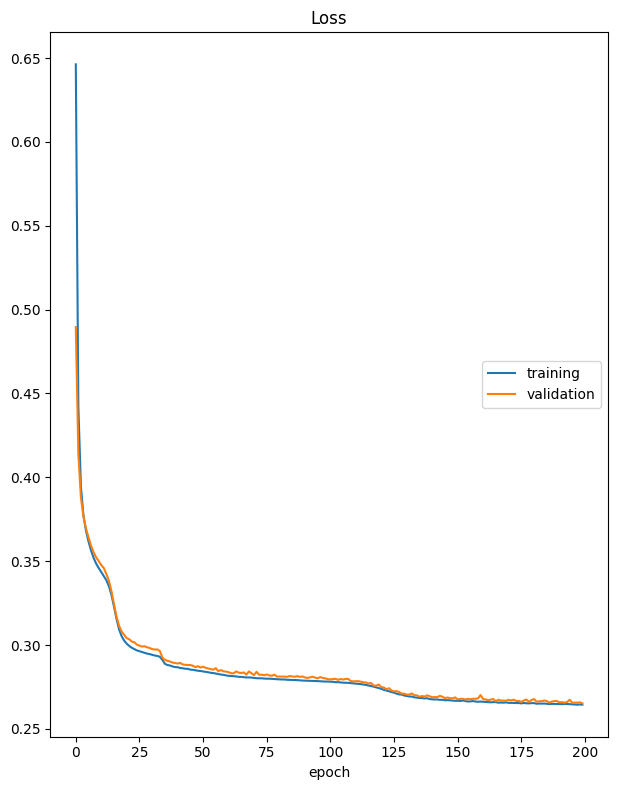

Loss
	training         	 (min:    0.264, max:    0.646, cur:    0.264)
	validation       	 (min:    0.265, max:    0.490, cur:    0.265)
604/604 [==============================] - 3s 4ms/step - loss: 0.2644 - val_loss: 0.2652
time: 7min 32s (started: 2023-05-30 13:18:20 +00:00)


In [42]:
nn_file = my_path + 'nn1.h5'

history = train_model(model, nn_file, X_tr_scaled, X_tr_scaled, seed=5, 
                      max_epochs=200)

Second train - Now with SMOTE function

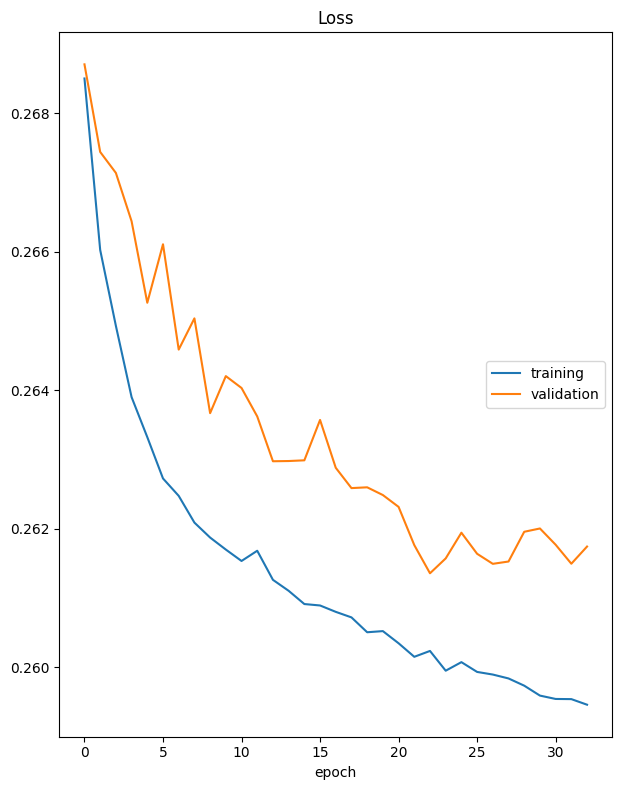

Loss
	training         	 (min:    0.259, max:    0.269, cur:    0.259)
	validation       	 (min:    0.261, max:    0.269, cur:    0.262)
Restoring model weights from the end of the best epoch: 23.
1197/1197 [==============================] - 4s 3ms/step - loss: 0.2595 - val_loss: 0.2617
Epoch 33: early stopping
time: 2min 21s (started: 2023-05-30 13:28:43 +00:00)


In [49]:
nn_file = my_path + 'nn1_SMOTE1.h5'

history = train_model(model, nn_file, X_tr_scaled1, X_tr_scaled1, seed=5, 
                      max_epochs=200)

Stop to early, lets try to low the learning rate

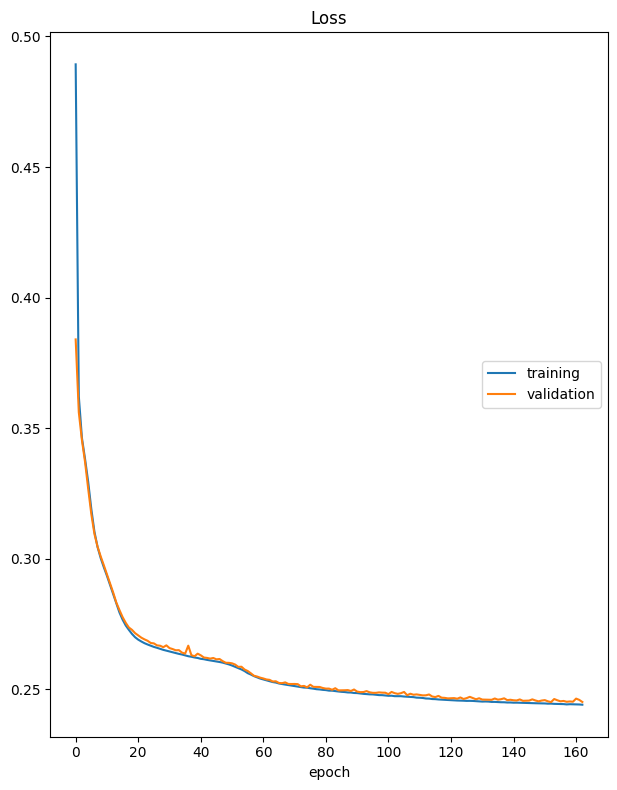

Loss
	training         	 (min:    0.244, max:    0.489, cur:    0.244)
	validation       	 (min:    0.245, max:    0.384, cur:    0.245)
Restoring model weights from the end of the best epoch: 153.
1197/1197 [==============================] - 4s 4ms/step - loss: 0.2442 - val_loss: 0.2452
Epoch 163: early stopping
time: 11min 50s (started: 2023-05-30 14:04:43 +00:00)


In [52]:
model = make_autoencoder(layer_sizes=first_architecture, learning_rate=0.005)
nn_file = my_path + 'nn1_SMOTE1_oo1.h5'

history = train_model(model, nn_file, X_tr_scaled1, X_tr_scaled1, seed=5, 
                      max_epochs=200)

# Anomaly Score

In [59]:
X_tr_reconstr = model.predict(X_tr_scaled1)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled1, axis=1)

755/755 [==============================] - 3s 3ms/step
time: 5.34 s (started: 2023-05-30 14:29:16 +00:00)


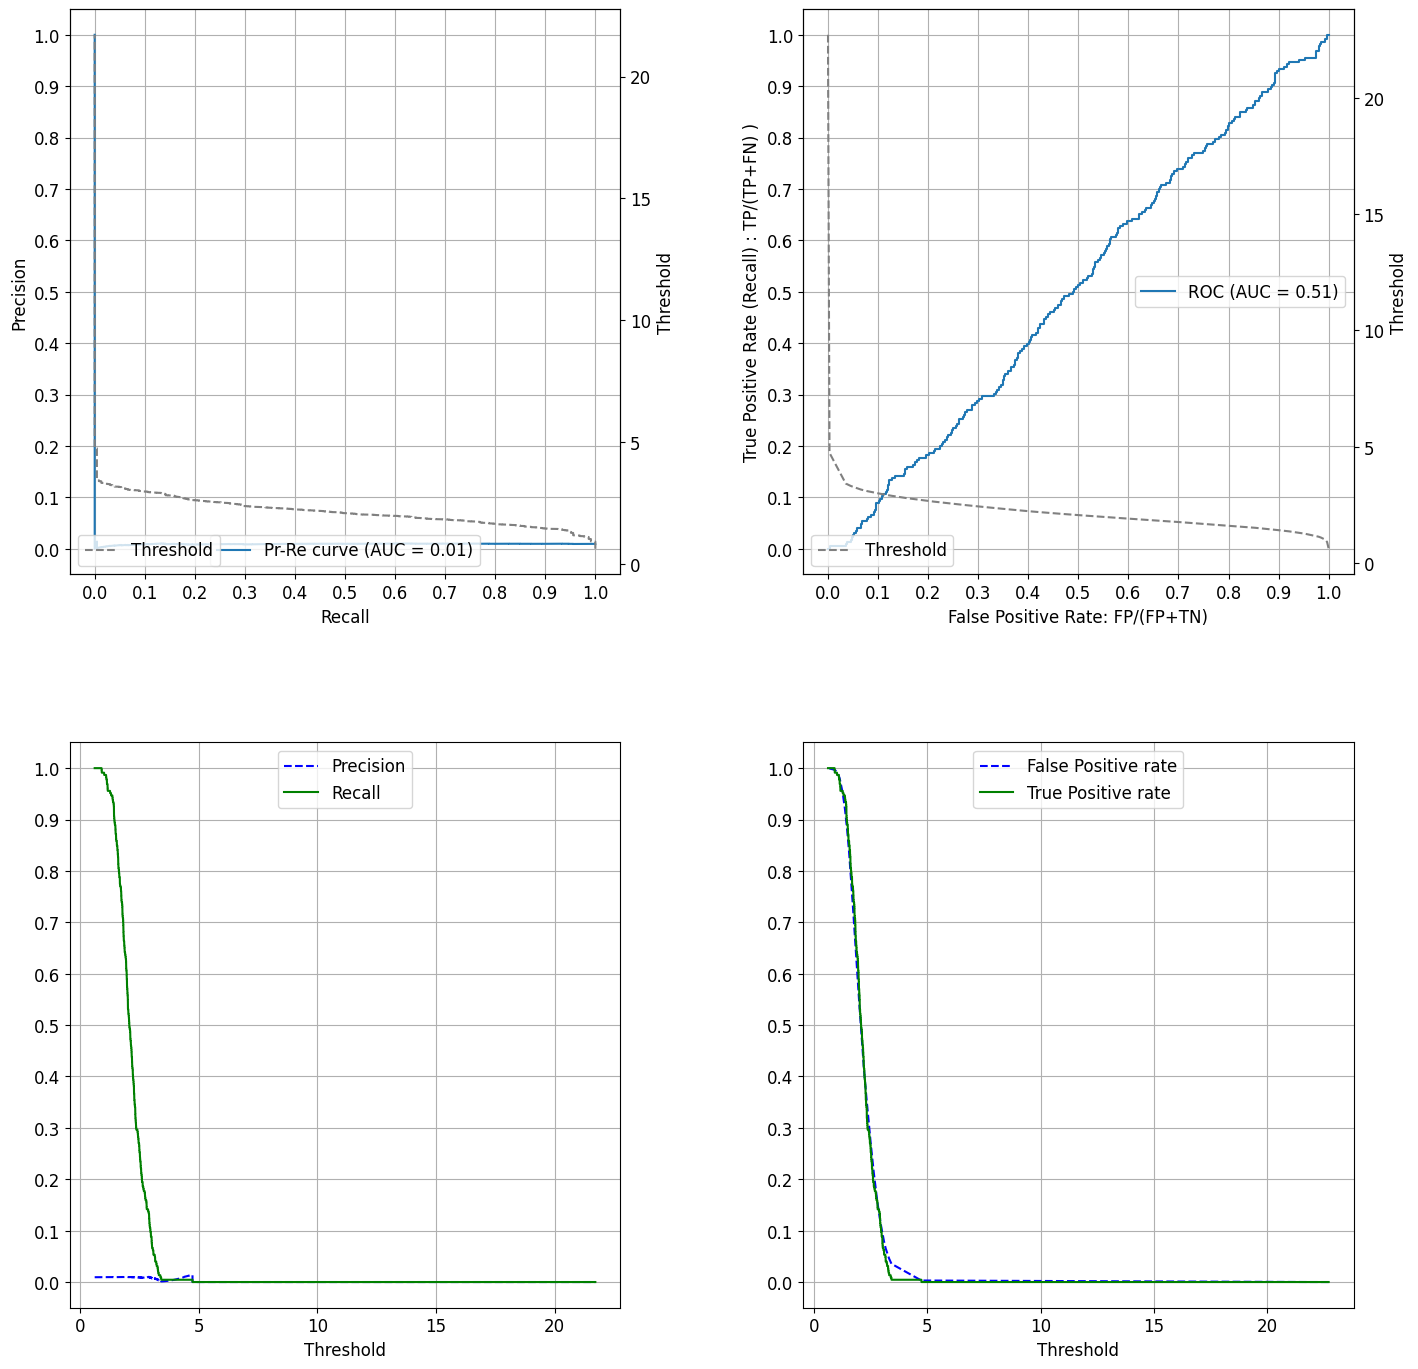

time: 1.6 s (started: 2023-05-30 14:49:23 +00:00)


In [84]:
evaluate_anomaly_detector(y_train, anomaly_scores)

Precision= 0.009338002334500583
Recall= 0.9911504424778761
False Positive Rate =  0.9928971337845742
True Positive Rate =  0.9911504424778761


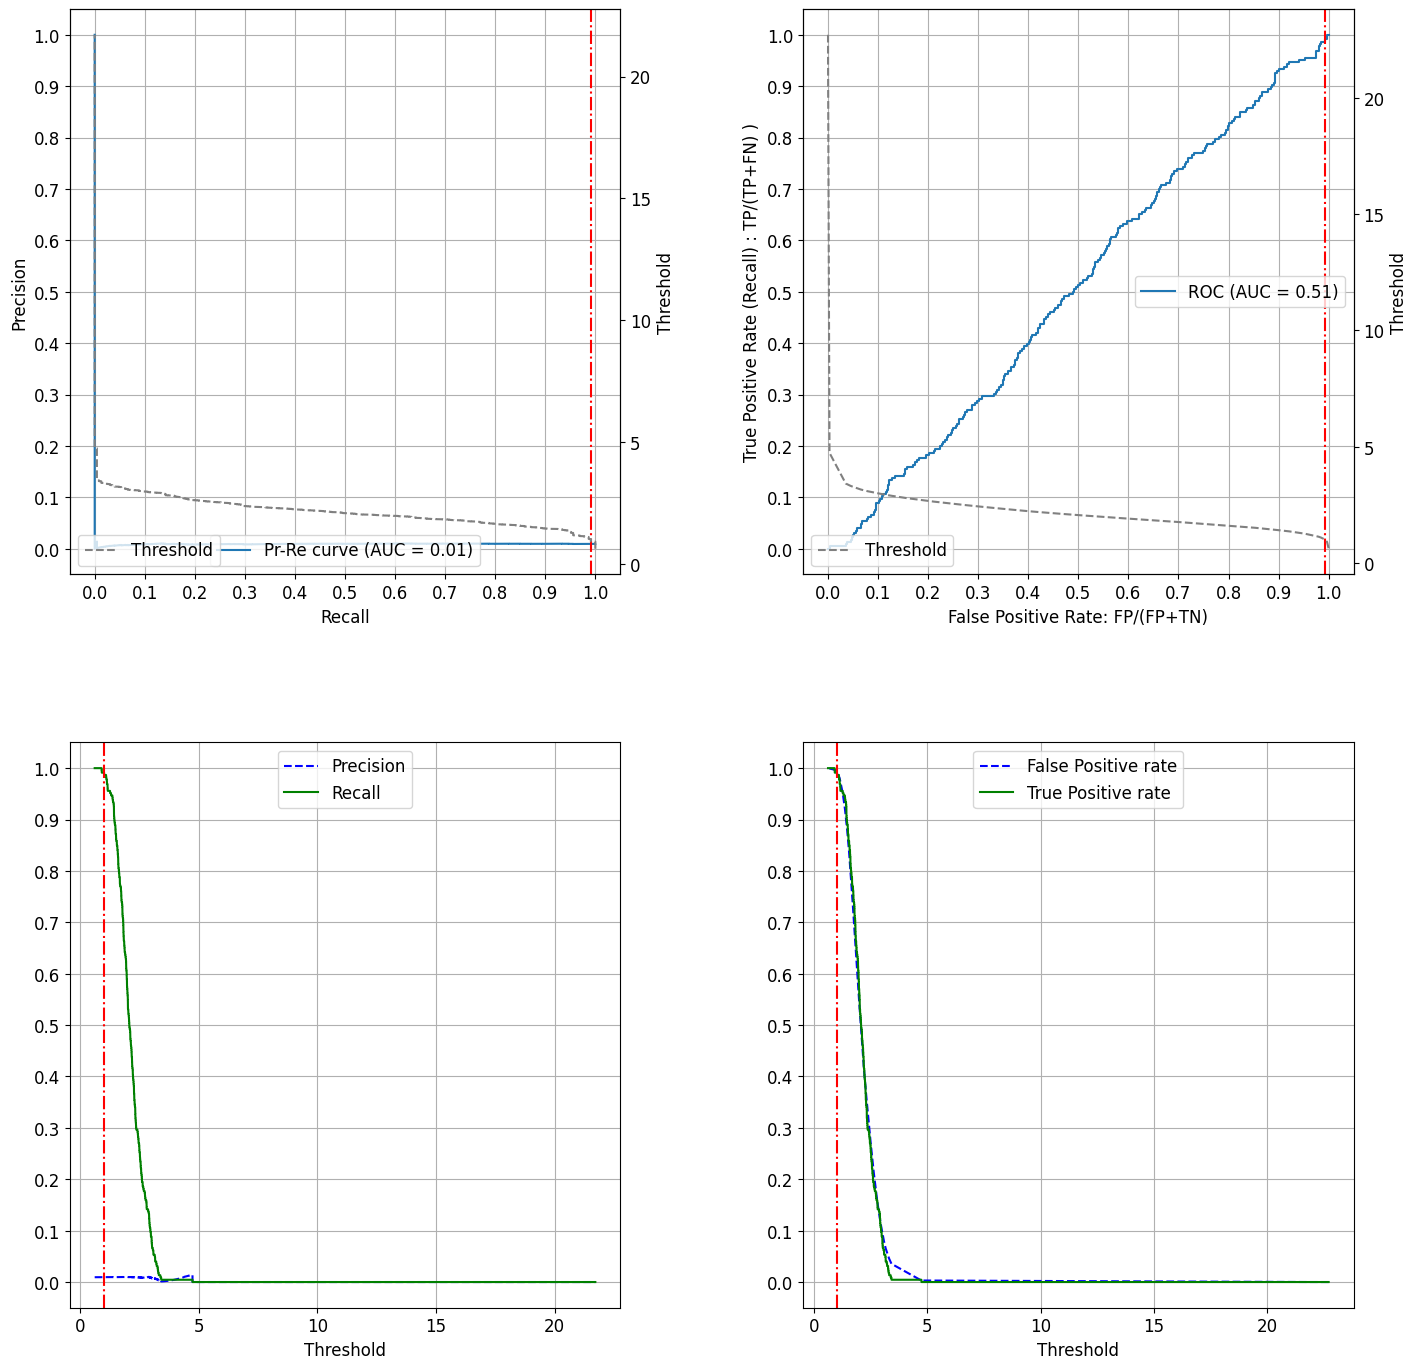

time: 4.55 s (started: 2023-05-30 14:55:28 +00:00)


In [91]:
threshold_selected = 1
evaluate_anomaly_detector(y_train, anomaly_scores, threshold_selected)

#Evaluate the model

In [93]:
X_test_scaled = scaler.transform(X_test)


time: 6.03 ms (started: 2023-05-30 14:55:49 +00:00)


In [108]:
X_test_reconstr = model.predict(X_test_scaled)
anomaly_scores = np.linalg.norm(X_test_reconstr - X_test_scaled, axis=1)

y_pred = (anomaly_scores >= threshold_selected)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)

print("Precision:", precision)
print("Recall: ", recall)
print("False Positive Rate:", fpr)

324/324 [==============================] - 1s 1ms/step
Precision: 0.007182044887780549
Recall:  0.9113924050632911
False Positive Rate: 0.9685675360062281
time: 707 ms (started: 2023-05-30 15:14:57 +00:00)


Normalized confusion matrix
[[0.03143246 0.96856754]
 [0.08860759 0.91139241]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

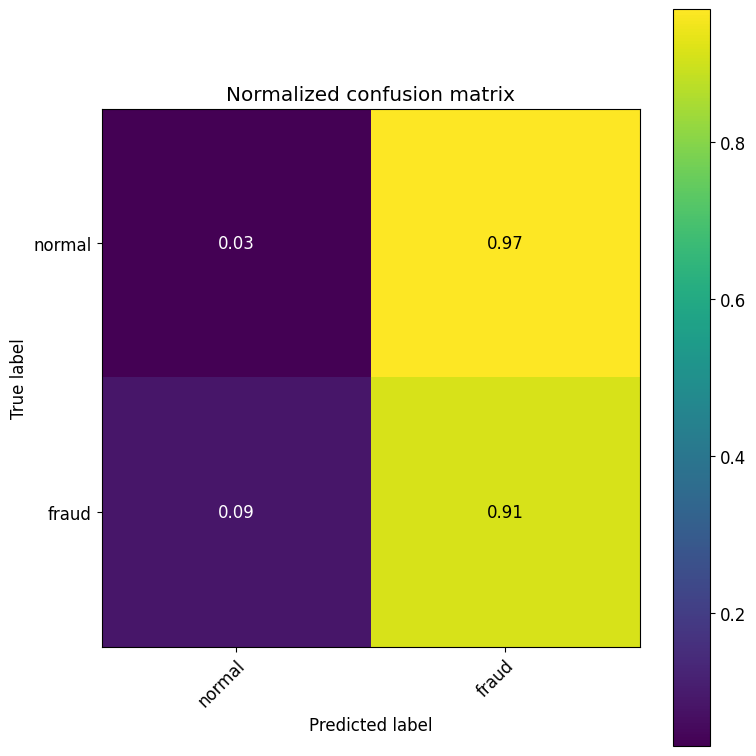

time: 408 ms (started: 2023-05-30 15:15:07 +00:00)


In [109]:
class_names = np.array(["normal", "fraud"])
plot_conf_mat(y_test, y_pred, class_names)

# Second Autoencoder

In [102]:
# Select the normal samples
normal_samples_idx = [i for i in range(len(y_train_balanced)) if y_train_balanced[i]==0 ]
print("Found ", len(normal_samples_idx), "normal samples over ", len(y_train))

X_tr_normal = X_tr_scaled[normal_samples_idx, :]
X_tr_normal.shape

Found  23934 normal samples over  24160


(23934, 12)

time: 158 ms (started: 2023-05-30 14:59:59 +00:00)


In [103]:
model = make_autoencoder(layer_sizes=first_architecture, learning_rate=0.005)

time: 106 ms (started: 2023-05-30 15:00:01 +00:00)


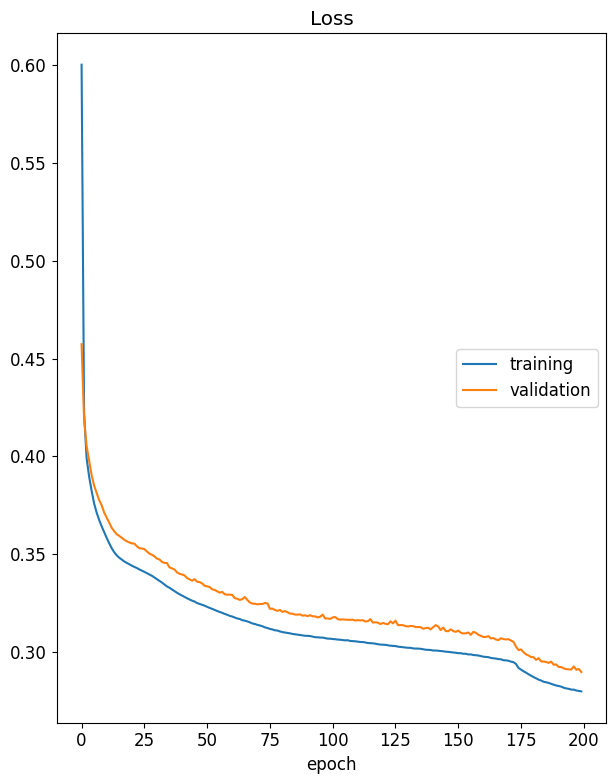

Loss
	training         	 (min:    0.280, max:    0.600, cur:    0.280)
	validation       	 (min:    0.290, max:    0.457, cur:    0.290)
599/599 [==============================] - 3s 5ms/step - loss: 0.2797 - val_loss: 0.2896
time: 8min 49s (started: 2023-05-30 15:00:29 +00:00)


In [104]:
nn_file = my_path + 'nn-normal-samples-lr_0.005.h5'
history = train_model(model, nn_file, X_tr_normal, X_tr_normal, seed=5, 
                      max_epochs=200)

In [105]:
X_tr_reconstr = model.predict(X_tr_scaled)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_tr_scaled, axis=1)

755/755 [==============================] - 2s 2ms/step
time: 2.94 s (started: 2023-05-30 15:10:20 +00:00)


Precision= 0.00989666715179741
Recall= 0.9026548672566371
False Positive Rate =  0.8527199799448484
True Positive Rate =  0.9026548672566371


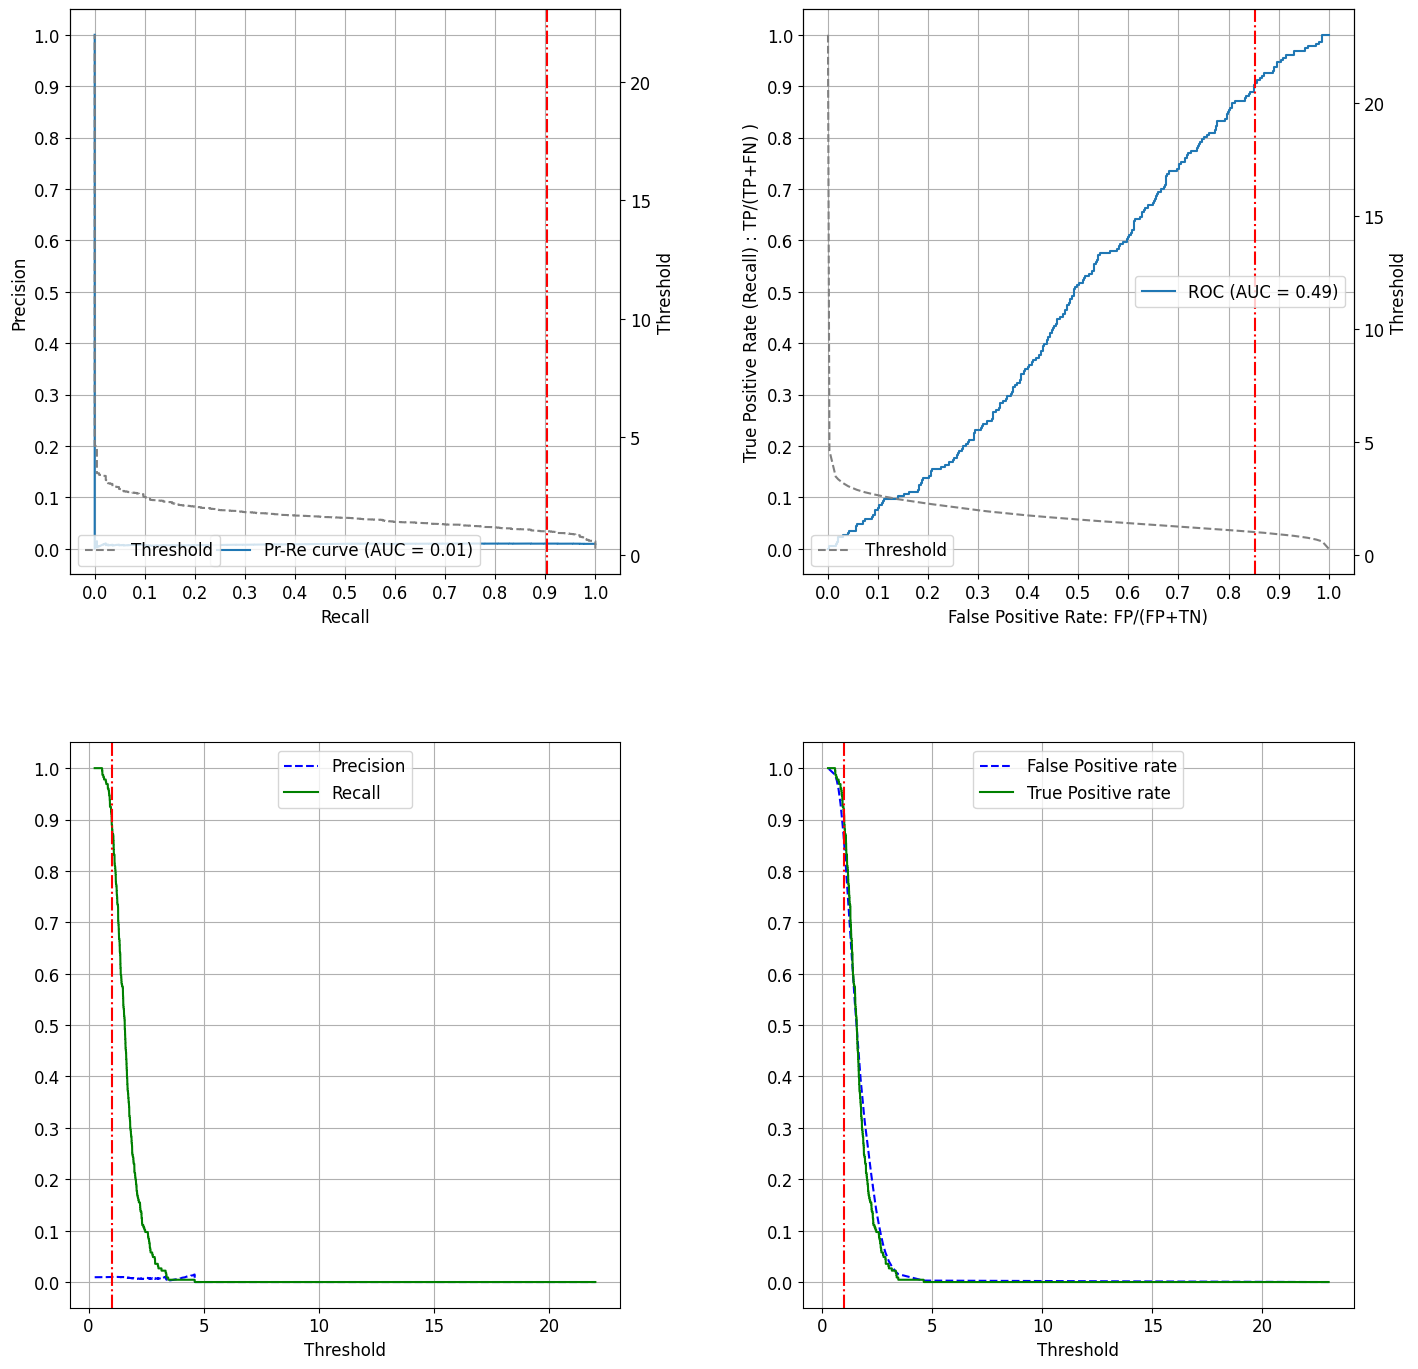

time: 2.68 s (started: 2023-05-30 15:10:46 +00:00)


In [106]:
evaluate_anomaly_detector(y_train, anomaly_scores, threshold_selected)


In [107]:
X_test_reconstr = model.predict(X_test_scaled)
anomaly_scores = np.linalg.norm(X_test_reconstr - X_test_scaled, axis=1)

y_pred = (anomaly_scores >= threshold_selected)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
fpr = false_positive_rate(y_test, y_pred)

print("Precision:", precision)
print("Recall: ", recall)
print("False Positive Rate:", fpr)

324/324 [==============================] - 1s 3ms/step
Precision: 0.007182044887780549
Recall:  0.9113924050632911
False Positive Rate: 0.9685675360062281
time: 2.8 s (started: 2023-05-30 15:14:19 +00:00)


Normalized confusion matrix
[[0.03143246 0.96856754]
 [0.08860759 0.91139241]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

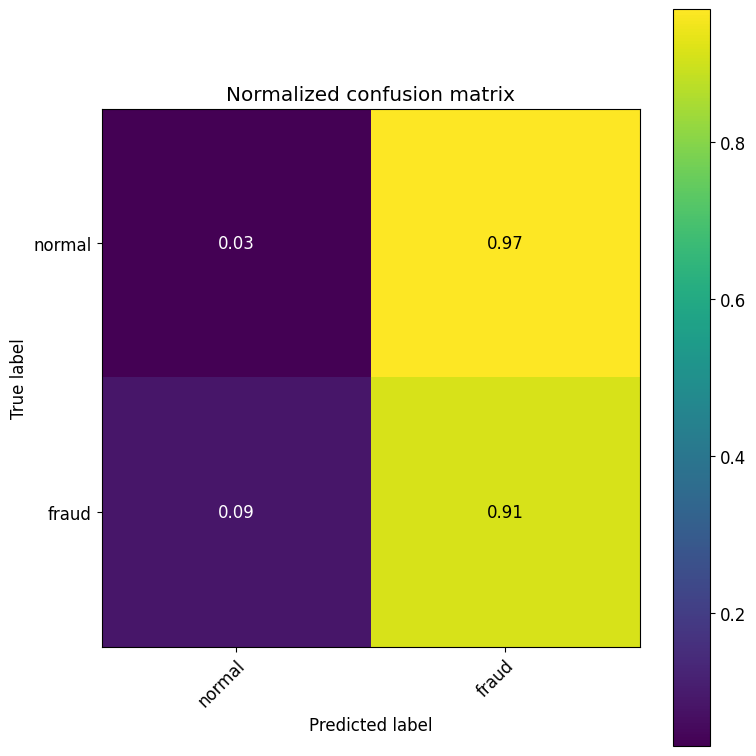

time: 725 ms (started: 2023-05-30 15:15:22 +00:00)


In [110]:
plot_conf_mat(y_test, y_pred, class_names)
